In [94]:
import pandas as pd
import sklearn.model_selection as skmodel
import sklearn.linear_model as sklin
import sklearn.metrics as skmetrics
import sklearn.preprocessing as skpre
import sklearn.neural_network as sknr
import sklearn.feature_selection as skft
import matplotlib.pyplot as plot
import numpy as np

In [126]:
try_usd = pd.read_excel('tryusd.xlsx', parse_dates=['Tarih']) 
interest_raw = pd.read_excel('interest.xlsx', parse_dates=['Date'])
inflation_raw = pd.read_excel('inflation.xlsx', parse_dates=['Date'])
pols_raw_1 = pd.read_excel('pols.xlsx', parse_dates=['Date'])
trade_balance_raw = pd.read_excel('trade_balance.xlsx', parse_dates=['Date'])

try_usd.rename(columns={'Tarih': 'Date'}, inplace=True)
pols_raw = pols_raw_1[['Date','political stability']]
law_raw = pols_raw_1[['Date','Rule of Law']]

try_usd.loc[:, 'Date'] = pd.to_datetime(try_usd['Date'])

In [243]:
end_date_train = '2021-01-01'
end_date_test = '2022-12-31'


train_tryusd = try_usd[try_usd['Date'] < end_date_train].copy()
test_tryusd = try_usd[(try_usd['Date'] > end_date_train) & (try_usd['Date'] <= end_date_test)].copy()

interest_train = interest_raw[interest_raw['Date'] < end_date_train].copy()
interest_test = interest_raw[(interest_raw['Date'] > end_date_train) & (interest_raw['Date'] <= end_date_test)].copy()

inflation_train = inflation_raw[inflation_raw['Date'] < end_date_train].copy()
inflation_test = inflation_raw[(inflation_raw['Date'] > end_date_train) & (interest_raw['Date'] <= end_date_test)].copy()

pols_train = pols_raw[pols_raw['Date'] < end_date_train].copy()
pols_test = pols_raw[(pols_raw['Date'] > end_date_train) & (pols_raw['Date'] <= end_date_test)].copy()

law_train = law_raw[law_raw['Date'] < end_date_train].copy()
law_test = law_raw[(law_raw['Date'] > end_date_train) & (law_raw['Date'] <= end_date_test)].copy()

trade_balance_train = trade_balance_raw[trade_balance_raw['Date'] < end_date_train].copy()
trade_balance_test = trade_balance_raw[(trade_balance_raw['Date'] > end_date_train) & (trade_balance_raw['Date'] <= end_date_test)].copy()

/var/folders/sf/3dndb1n93zg_nyj904y9n4180000gn/T/ipykernel_94921/169794088.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  inflation_test = inflation_raw[(inflation_raw['Date'] > end_date_train) & (interest_raw['Date'] <= end_date_test)].copy()


In [244]:
len(inflation_test)

23

In [245]:
inflation_train.loc[:, 'Date'] = pd.to_datetime(inflation_train['Date'])
inflation_test.loc[:, 'Date'] = pd.to_datetime(inflation_test['Date'])

interest_train.loc[:, 'Date'] = pd.to_datetime(interest_train['Date'])
interest_test.loc[:, 'Date'] = pd.to_datetime(interest_test['Date'])

pols_train.loc[:, 'Date'] = pd.to_datetime(pols_train['Date'])
pols_test.loc[:, 'Date'] = pd.to_datetime(pols_test['Date'])

law_train.loc[:, 'Date'] = pd.to_datetime(law_train['Date'])
law_test.loc[:, 'Date'] = pd.to_datetime(law_test['Date'])

trade_balance_train.loc[:, 'Date'] = pd.to_datetime(trade_balance_train['Date'])
trade_balance_test.loc[:, 'Date'] = pd.to_datetime(trade_balance_test['Date'])

In [246]:
train_data = pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(train_tryusd, inflation_train, on='Date', how='inner'), 
                                               interest_train, on='Date', how='inner'), 
                                        pols_train, on='Date', how='inner'), 
                               law_train, on='Date',how='inner'), 
                      trade_balance_train, on='Date', how='inner')

test_data = pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(test_tryusd, inflation_test, on='Date', how='inner'), 
                                               interest_test, on='Date', how='inner'), 
                                        pols_test, on='Date', how='inner'), 
                               law_test, on='Date',how='inner'), 
                      trade_balance_test, on='Date', how='inner')



In [247]:
train_data['Regime_Dummy'] = np.where(train_data['Date'].dt.year >= 2018, 1, 0)
test_data['Regime_Dummy'] = np.where(test_data['Date'].dt.year >= 2018, 1, 0)

In [248]:
X_train = train_data[['Interest Rate Differential', 'Inflation Differential', 'political stability', 'Trade Balance: Commodities for Turkiye ($)', 'Regime_Dummy']]
y_train = train_data['TRY/USD']

X_test = test_data[['Interest Rate Differential', 'Inflation Differential', 'political stability', 'Trade Balance: Commodities for Turkiye ($)', 'Regime_Dummy']]
y_test = test_data['TRY/USD']


In [249]:
scaler = skpre.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [250]:
models = {
    'Linear Regression': sklin.LinearRegression(),
    'Lasso': sklin.Lasso(alpha=0.1),
    'Ridge': sklin.Ridge(alpha=1.0),
    'ElasticNet': sklin.ElasticNet(alpha=0.1, l1_ratio=0.5),
    'Neural Network': sknr.MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000)
}

In [251]:
results = {}
coefficients = {}
predictions = {}
for i, j in models.items():
    j.fit(X_train_scaled, y_train)
    preds = j.predict(X_test_scaled)
    mse = skmetrics.mean_squared_error(y_test, preds)
    results[i] = mse
    predictions[i] = preds
    
    if hasattr(j, 'coef_'):
        coefficients[i] = dict(zip(X_train.columns, j.coef_))
        print(f'{i} Coefficients:')
        for feature, coef in coefficients[i].items():
            print(f'{feature} = {coef:.6f}', end='  ')
        print()  # To ensure each model's output is printed on a new line
    print(f'{i} - Test MSE: {mse}')

Linear Regression Coefficients:
Interest Rate Differential = -0.181053  Inflation Differential = 0.121832  political stability = -0.517387  Trade Balance: Commodities for Turkiye ($) = 0.102227  Regime_Dummy = 1.299635  
Linear Regression - Test MSE: 67.67669012964524
Lasso Coefficients:
Interest Rate Differential = -0.000000  Inflation Differential = 0.000000  political stability = -0.459350  Trade Balance: Commodities for Turkiye ($) = 0.000000  Regime_Dummy = 1.252042  
Lasso - Test MSE: 75.28636850628088
Ridge Coefficients:
Interest Rate Differential = -0.179616  Inflation Differential = 0.120181  political stability = -0.516697  Trade Balance: Commodities for Turkiye ($) = 0.102773  Regime_Dummy = 1.294198  
Ridge - Test MSE: 67.97364159356414
ElasticNet Coefficients:
Interest Rate Differential = -0.000000  Inflation Differential = 0.000000  political stability = -0.490514  Trade Balance: Commodities for Turkiye ($) = 0.007553  Regime_Dummy = 1.232152  
ElasticNet - Test MSE: 76.1

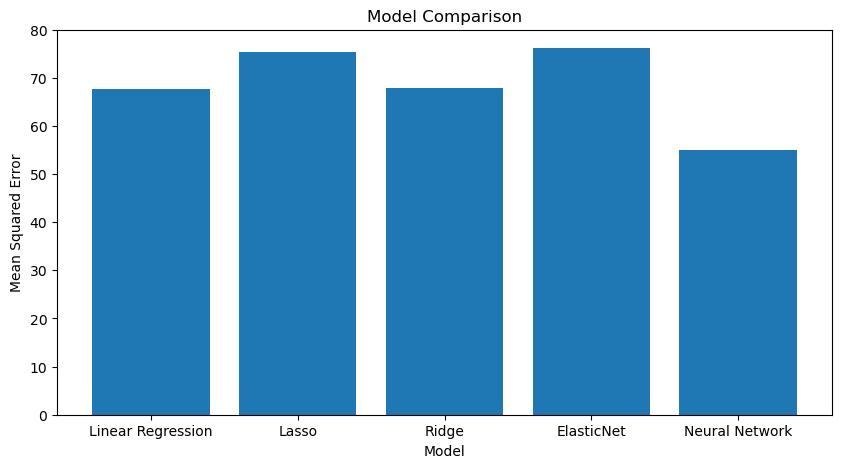

In [252]:
plot.figure(figsize=(10, 5))
plot.bar(results.keys(), results.values())
plot.xlabel('Model')
plot.ylabel('Mean Squared Error')
plot.title('Model Comparison')
plot.show()

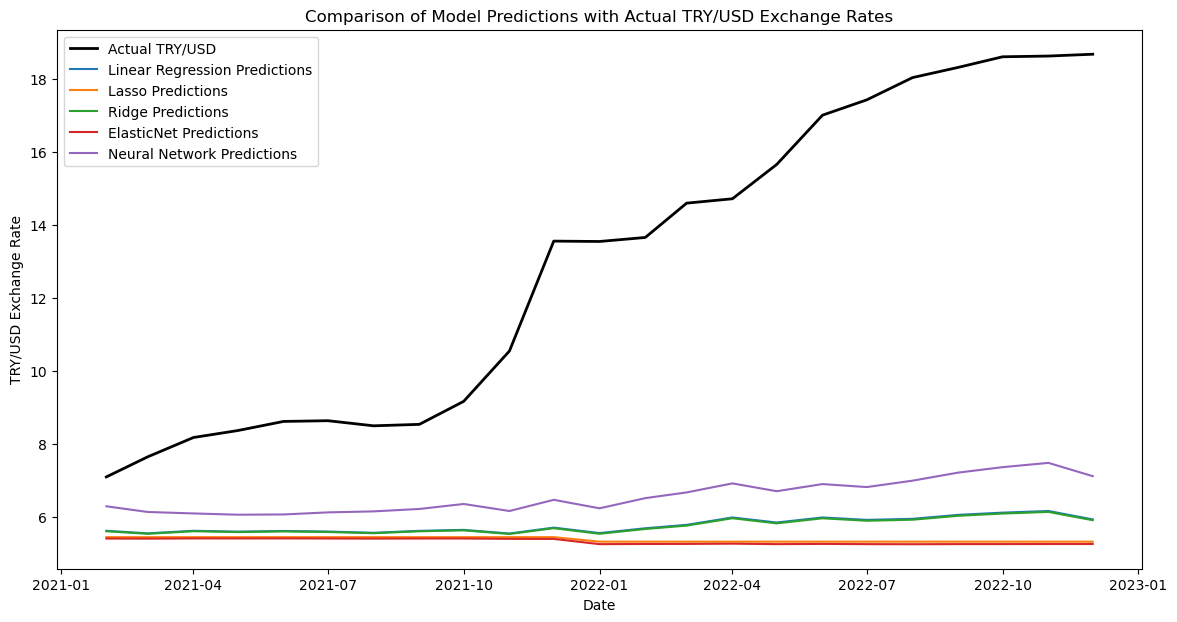

In [258]:
plot.figure(figsize=(14, 7))
plot.plot(test_data['Date'], y_test, label='Actual TRY/USD', color='black', linewidth=3)
for model_name, preds in predictions.items():
    plot.plot(test_data['Date'], preds, label=f'{model_name} Predictions')
    
plot.title('Comparison of Model Predictions with Actual TRY/USD Exchange Rates')
plot.xlabel('Date')
plot.ylabel('TRY/USD Exchange Rate')
plot.legend()
plot.show() 